# Image Classification - Final Project Deep Learning

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Evaluasi model
from sklearn.metrics import classification_report, confusion_matrix

Nama Kelas :  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


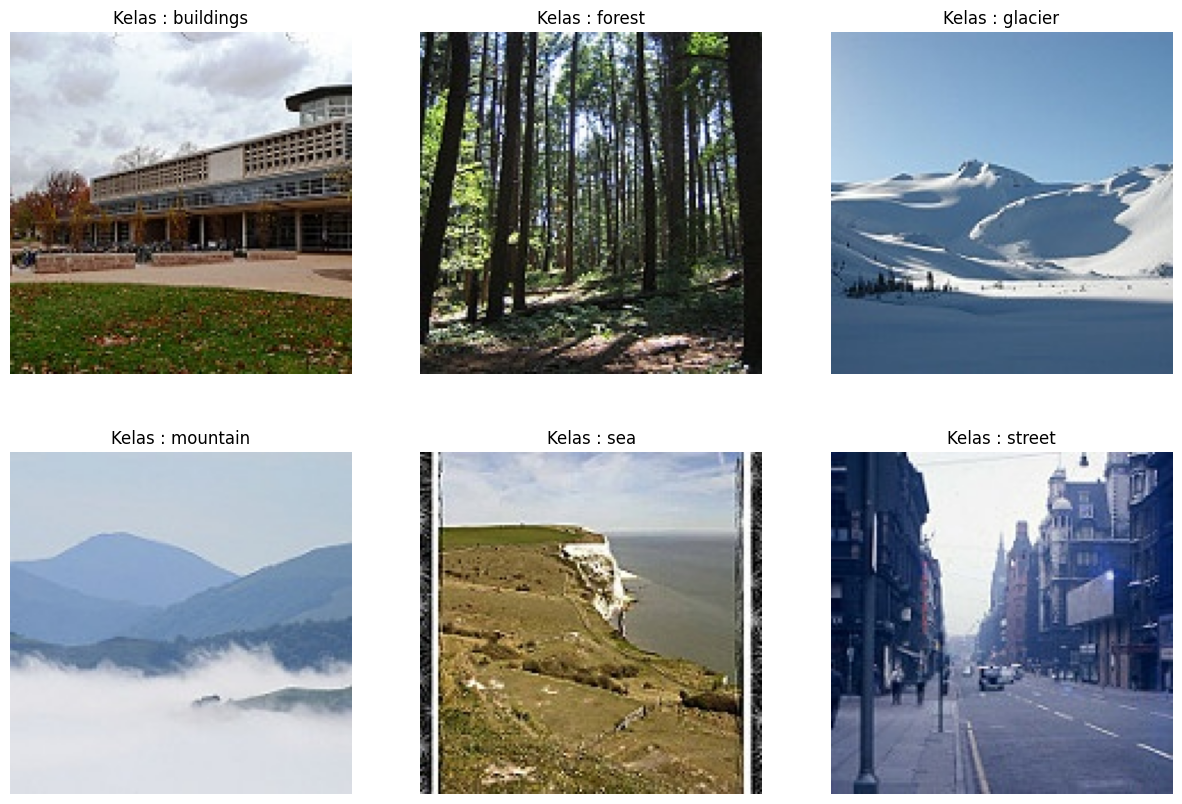

In [15]:
base_dir = '/kaggle/input/intel-image-classification'
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

# Identifikasi & TAmpilkan kelas
class_names = sorted(os.listdir(train_dir))
print("Nama Kelas : ", class_names)

plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_file = os.listdir(class_path)[0]
    img = plt.imread(os.path.join(class_path, image_file))

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Kelas : {class_name}")
    plt.axis('off')

plt.show()

In [16]:
# tetapkan ukuran gambarr
IMG_SIZE = (150, 150)
BATCH_SIZE = 16  # jumlah gambar

train_datagen = ImageDataGenerator(
    rescale=1.255,              # normalisais pixel 0-255 jadi 0-1
    rotation_range=20,          # rotasi acak max 20°
    width_shift_range=0.2,      # geser lebar
    height_shift_range=0.2,     # geser tinggi
    shear_range=0.2,            # miringkan
    zoom_range=0.2,             # zoom
    horizontal_flip=True,       # balik horizontal
    fill_mode='nearest',        # isi pixel kosong hasil augmentasi
    validation_split=0.2        # 20% untuk validasi
)

# data test, normalisasi tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

# buat generator untuk mengambil gambar dari folder training
train_generator = train_datagen.flow_from_directory(
    train_dir,               
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,        # ambil gambar per batch
    class_mode='categorical',     # mode klasifikasi multi-class
    subset='training'             # 80% sisa validatton_split 
)
# buat generator untuk valiadasi gambar di folder testing
validation_generator=test_datagen.flow_from_directory(
    test_dir,                      
    target_size=IMG_SIZE,          
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False               # tanpa diacak
)

Found 11230 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [17]:
# base model berdasar resnet50, dengan hasil dari training di imagenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# cegah proses untuk lapisan resnet agar bobot tidak berubah
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output                 # ambil output dari base model
x = GlobalAveragePooling2D()(x)       # ratakan output resnet jadi 1 vektor panjang
x = Dense(512, activation='relu')(x)  # tambah lapisan dense untuk pola kompleks
x = Dropout(0.5)(x)                   # cegah overfitting, dengan drop 50% neruon secara acak

# lapisan output: jumlah neuron = jumlah kelas, softmax -> probabilitas tiap kelas
predictions = Dense(len(class_names), activation='softmax')(x)

# model baru dengan inputan dari base model
model = Model(inputs=base_model.input, outputs=predictions)
# config model untuk training
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
#  ringkasan arsitektur model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.7232 - loss: 0.7462 - val_accuracy: 0.1700 - val_loss: 1.8924
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 70s 99ms/step - accuracy: 0.8339 - loss: 0.4732 - val_accuracy: 0.1700 - val_loss: 1.9501
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 70s 99ms/step - accuracy: 0.8539 - loss: 0.3945 - val_accuracy: 0.1650 - val_loss: 1.8966
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - accuracy: 0.8665 - loss: 0.3706 - val_accuracy: 0.1557 - val_loss: 1.8813
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - accuracy: 0.8698 - loss: 0.3582 - val_accuracy: 0.1620 - val_loss: 1.8839
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 71s 100ms/step - accuracy: 0.8838 - loss: 0.3207 - val_accuracy: 0.1693 - val_loss: 1.8910
Epoch 7/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - accuracy: 0.8727 - loss: 0.3480 - val_accuracy: 0.1603 - val_loss: 1.8747
Epoch 8/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.8894 - loss: 0.

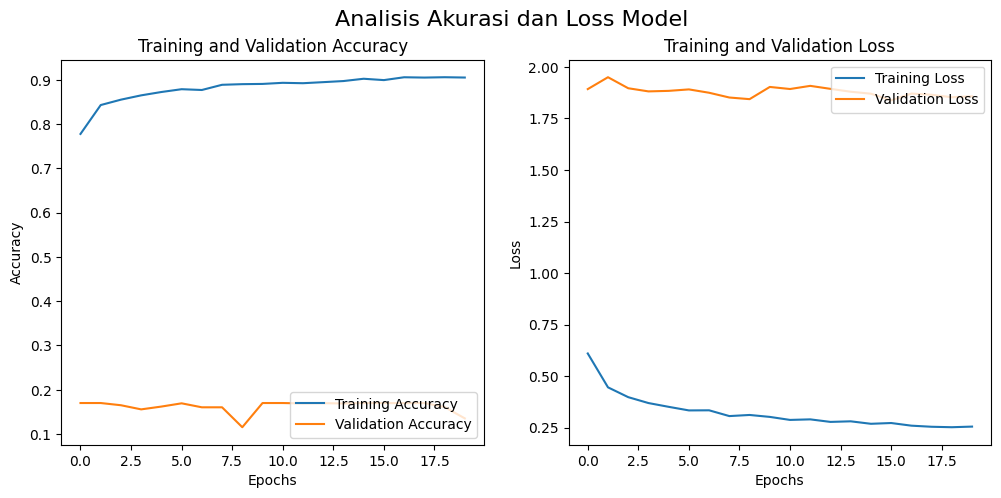

In [20]:
# extract data traiing dari history
acc = history.history['accuracy']         
val_acc = history.history['val_accuracy']
loss = history.history['loss']            
val_loss = history.history['val_loss']    
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

# plot akurasi 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.suptitle('Analisis Akurasi dan Loss Model', fontsize=16)
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3825 - loss: 1.7521

Akurasi pada data test: 13.53%
Loss pada data test: 1.8576
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step


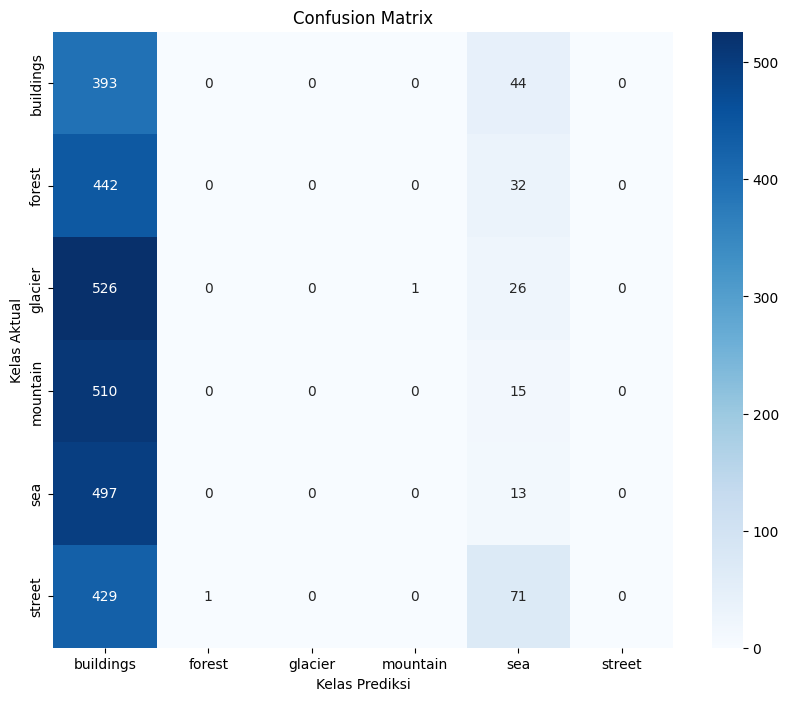

In [21]:
# evaluasi model pda dataa validasi
loss, accuracy = model.evaluate(validation_generator)
print(f"\nAkurasi pada data test: {accuracy*100:.2f}%")
print(f"Loss pada data test: {loss:.4f}")

# prediksi kelas data validais
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)      # ambil idx kelas prediksi
y_true = validation_generator.classes   # label asli

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

model.save('model_klasifikasi_gambar_terbaik.h5')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Kelas Aktual')
plt.xlabel('Kelas Prediksi')
plt.show()

In [22]:
print("\nClassification REport:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification REport:

              precision    recall  f1-score   support

   buildings       0.14      0.90      0.24       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.00      0.00      0.00       525
         sea       0.06      0.03      0.04       510
      street       0.00      0.00      0.00       501

    accuracy                           0.14      3000
   macro avg       0.03      0.15      0.05      3000
weighted avg       0.03      0.14      0.04      3000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


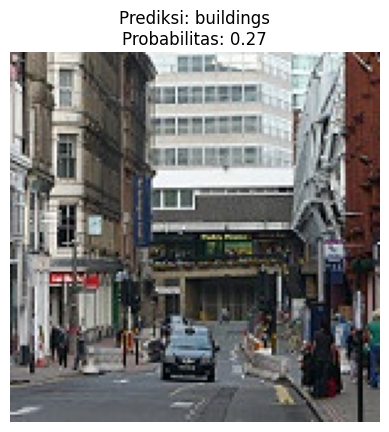

Hasil Prediksi: buildings
Distribusi Probabilitas: [0.26570135 0.09622326 0.14584287 0.18123029 0.20808677 0.10291545]


In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

saved_model = load_model('model_klasifikasi_gambar_terbaik.h5')

class_names = list(train_generator.class_indices.keys())

image_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred/10012.jpg'

def preprocess_image(img_path):
    # laod gambar, set ke 150X150 
    img = image.load_img(img_path, target_size=(150, 150))
    
    # ubah gambar menjadi array numpy
    img_array = image.img_to_array(img)
    
    # tambah dimensi batch
    img_array_expanded = np.expand_dims(img_array, axis=0)
    
    # normalisasi pixel gambar 
    return img_array_expanded / 255.

# proses gambar
processed_img = preprocess_image(image_path)
prediction = saved_model.predict(processed_img)
# get index kelas probabilitas tertinggi
predicted_class_index = np.argmax(prediction, axis=1)[0]
# get nama kelas dari indeksnya
predicted_class_name = class_names[predicted_class_index]

plt.imshow(image.load_img(image_path))
plt.title(f"Prediksi: {predicted_class_name}\nProbabilitas: {prediction[0][predicted_class_index]:.2f}")
plt.axis('off')
plt.show()

print(f"Hasil Prediksi: {predicted_class_name}")
print(f"Distribusi Probabilitas: {prediction[0]}")